#### Imports


In [1]:
from zoish.feature_selectors.select_by_shuffling import SelectByShufflingFeatureSelector
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import OrdinalEncoder
import xgboost
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.linear_model import LinearRegression

2023-02-24 21:08:37,430 :: matplotlib :: matplotlib data path: /Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/matplotlib/mpl-data
2023-02-24 21:08:37,446 :: matplotlib :: CONFIGDIR=/Users/hjavedani/.matplotlib
2023-02-24 21:08:37,457 :: matplotlib :: interactive is False
2023-02-24 21:08:37,458 :: matplotlib :: platform is darwin
2023-02-24 21:08:37,459 :: matplotlib :: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_virtualenv', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib._abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_colle

#### Computer Hardware Data Set (a regression problem)
  
###### https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
# column names
col_names=[
    "vendor name",
    "Model Name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')


#### Train test split

In [3]:
X = data.loc[:, data.columns != "PRP"]
y = data.loc[:, data.columns == "PRP"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)


#### Define feature selector step 


In [4]:
select_by_shuffling_feature_selector_factory = (
        SelectByShufflingFeatureSelector.select_by_shuffling_selector_factory.set_model_params(
        X=X_train,
        y=y_train,
        verbose=0,
        random_state=0,
        estimator=xgboost.XGBRegressor(),
        estimator_params={
            "max_depth": [4, 5],
        },
        fit_params = {
            "sample_weight": None,
        },
        method="tunesearch",
        threshold=0.02,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
    ).set_select_by_shuffling_params(
        cv=2,
        variables=None,
        scoring='r2',
        confirm_variables=False,
        
    )
    .set_tunesearchcv_params(
        measure_of_accuracy=None,
        verbose=3,
        n_jobs=None,
        cv=3,
        early_stopping=None, 
        n_trials=10,
        # if measure_of_accuracy=None, scoring will be used.
        scoring='explained_variance', 
        refit=True, 
        error_score='raise', 
        return_train_score=False, 
        local_dir='~/ray_results', 
        name=None, 
        max_iters=1, 
        search_optimization='hyperopt',
        use_gpu=False, 
        loggers=None, 
        pipeline_auto_early_stop=True, 
        stopper=None, 
        time_budget_s=None, 
        mode=None,
        search_kwargs=None, 

)
)

#### Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


#### Define pipeline

In [6]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ("sbsfs", select_by_shuffling_feature_selector_factory),
            # add any regression model from sklearn e.g., LinearRegression
            ('regression', LinearRegression())


 ])



#### Run Pipeline

In [7]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


2023-02-24 21:09:05,918 :: dev :: Building Best Estimator by TuneSearchCV !
2023-02-24 21:09:05,918 :: dev :: Building Best Estimator by TuneSearchCV !
2023-02-24 21:09:05,921 :: dev :: The optimization will be based on explained_variance metric!
2023-02-24 21:09:05,921 :: dev :: The optimization will be based on explained_variance metric!
2023-02-24 21:09:05,925 :: ray.tune.tune :: Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.


2023-02-24 21:09:11,333	INFO worker.py:1538 -- Started a local Ray instance.


Trial name,average_test_score,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,split0_test_score,split1_test_score,split2_test_score,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_Trainable_1edc8a68,0.854731,2023-02-24_21-09-44,True,,491d0d6232f844bf9a2ec63707c8d964,hjavedani-MB,1,127.0.0.1,0.854731,73913,0.895637,0.761365,0.90719,0.155351,0.155351,0.155351,1677301784,0,,1,1edc8a68,0.19498
_Trainable_2c08072d,0.854731,2023-02-24_21-09-44,True,,491d0d6232f844bf9a2ec63707c8d964,hjavedani-MB,1,127.0.0.1,0.854731,73913,0.895637,0.761365,0.90719,0.298797,0.298797,0.298797,1677301784,0,,1,2c08072d,0.19498
_Trainable_520758b2,0.850987,2023-02-24_21-09-44,True,,0b29b1964f584b39a082136b63893f8f,hjavedani-MB,1,127.0.0.1,0.850987,73923,0.887395,0.777685,0.88788,0.153406,0.153406,0.153406,1677301784,0,,1,520758b2,0.153839
_Trainable_561c41ba,0.854731,2023-02-24_21-10-01,True,,0e1f216f14ac4410bd387460e43e8aa4,hjavedani-MB,1,127.0.0.1,0.854731,73931,0.895637,0.761365,0.90719,0.182303,0.182303,0.182303,1677301801,0,,1,561c41ba,0.239339
_Trainable_6c5b1d3b,0.854731,2023-02-24_21-09-32,True,,491d0d6232f844bf9a2ec63707c8d964,hjavedani-MB,1,127.0.0.1,0.854731,73913,0.895637,0.761365,0.90719,0.173391,0.173391,0.173391,1677301772,0,,1,6c5b1d3b,0.19498
_Trainable_858e023b,0.850987,2023-02-24_21-09-44,True,,0b29b1964f584b39a082136b63893f8f,hjavedani-MB,1,127.0.0.1,0.850987,73923,0.887395,0.777685,0.88788,0.353323,0.353323,0.353323,1677301784,0,,1,858e023b,0.153839
_Trainable_8a1d3f99,0.854731,2023-02-24_21-10-02,True,,031a584a288a4cada7b0c5ae57b45207,hjavedani-MB,1,127.0.0.1,0.854731,73929,0.895637,0.761365,0.90719,0.229659,0.229659,0.229659,1677301802,0,,1,8a1d3f99,0.176193
_Trainable_c3f42cb2,0.850987,2023-02-24_21-10-01,True,,146e82ccd7464e29866db65b47050b5d,hjavedani-MB,1,127.0.0.1,0.850987,73927,0.887395,0.777685,0.88788,0.22261,0.22261,0.22261,1677301801,0,,1,c3f42cb2,0.287544
_Trainable_d31d6c6e,0.854731,2023-02-24_21-10-01,True,,de13c950708049c0aeaeb1711a132a2d,hjavedani-MB,1,127.0.0.1,0.854731,73930,0.895637,0.761365,0.90719,0.204116,0.204116,0.204116,1677301801,0,,1,d31d6c6e,0.279793
_Trainable_e5ba9062,0.850987,2023-02-24_21-10-01,True,,bd85432aadec4bdba03c2f75383b475c,hjavedani-MB,1,127.0.0.1,0.850987,73928,0.887395,0.777685,0.88788,0.202622,0.202622,0.202622,1677301801,0,,1,e5ba9062,0.259213


2023-02-24 21:10:02,499	INFO tune.py:762 -- Total run time: 46.52 seconds (42.21 seconds for the tuning loop).
/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['vendor name', 'Model Name', 'CHMIN']
{'vendor name': -0.010591318144849038, 'Model Name': 0.0029131413785535853, 'MYCT': 0.03760482972145718, 'MMIN': 0.6904471284116217, 'MMAX': 0.030860577749235785, 'CACH': 0.03472517626928573, 'CHMIN': 0.006465260752226976, 'CHMAX': 0.1902390645624934}
dict_keys(['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMAX'])
       0         1
0   MYCT  0.037605
1   MMIN  0.690447
2   MMAX  0.030861
3   CACH  0.034725
4  CHMAX  0.190239
['CACH', 'MYCT', 'MMAX', 'CHMAX', 'MMIN']


#### plot

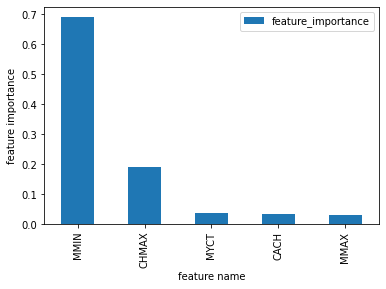

SelectByShufflingFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime            50-750-...
                                 local_dir='~/ray_results', max_iters=1,
                                 method='tunesearch', n_features=5, n_trials=10,
                                 pipeline_auto_early_stop=True, random_state=0,
                                 refit=True, return_train_score=False,
                                 scoring='explained_variance',
                                 search_optimization='hyperopt', threshold=0.02,
                                 use_gpu=False, verbose=3,
                                 y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])

In [8]:
SelectByShufflingFeatureSelector.select_by_shuffling_selector_factory.plot_features_all(
    path_to_save_plot="../plots/single_random_search_classification"
)


#### Check performance of the Pipeline

In [9]:
print('r2 score : ')
print(r2_score(y_test,y_pred))


r2 score : 
0.9199440731541878


#### Get list of features and grades

In [10]:
SelectByShufflingFeatureSelector.select_by_shuffling_selector_factory.get_info_of_features_and_grades()

list of selected features+list of obligatory features that must be in                 model-list of features to drop before any selection               ['CACH', 'MYCT', 'MMAX', 'CHMAX', 'MMIN']
list of selected features and their grades
---------------------------------------------------------
  column_name feature_importance
1        MMIN           0.690447
4       CHMAX           0.190239
0        MYCT           0.037605
3        CACH           0.034725
2        MMAX           0.030861
Note: list of obligatory features that must be in model-list of                         features to drop before any selection also has considered !


SelectByShufflingFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime            50-750-...
                                 local_dir='~/ray_results', max_iters=1,
                                 method='tunesearch', n_features=5, n_trials=10,
                                 pipeline_auto_early_stop=True, random_state=0,
                                 refit=True, return_train_score=False,
                                 scoring='explained_variance',
                                 search_optimization='hyperopt', threshold=0.02,
                                 use_gpu=False, verbose=3,
                                 y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])

#### Only list of selected features is :

In [11]:
print(SelectByShufflingFeatureSelector.select_by_shuffling_selector_factory.get_list_of_features())

['CACH', 'MYCT', 'MMAX', 'CHMAX', 'MMIN']


#### Get access to feature selector instance

In [12]:
print(SelectByShufflingFeatureSelector.select_by_shuffling_selector_factory.get_feature_selector_instance())

SelectByShuffling(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                         callbacks=None, colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, gamma=0, gpu_id=-1,
                                         grow_policy='depthwise',
                                         importance_type=None,
                                         interaction_constraints='',
                                         learning_rate=0.300000012, max_bin=256,
                                         max_cat_to_onehot=4, max_delta_step=0,
                                         max_depth=4, max_leaves=0,
                                         min_child_weight=1, missing=nan,
                                         monotone_

#### Get list of features and grades

In [13]:
SelectByShufflingFeatureSelector.select_by_shuffling_selector_factory.get_info_of_features_and_grades()

list of selected features+list of obligatory features that must be in                 model-list of features to drop before any selection               ['CACH', 'MYCT', 'MMAX', 'CHMAX', 'MMIN']
list of selected features and their grades
---------------------------------------------------------
  column_name feature_importance
1        MMIN           0.690447
4       CHMAX           0.190239
0        MYCT           0.037605
3        CACH           0.034725
2        MMAX           0.030861
Note: list of obligatory features that must be in model-list of                         features to drop before any selection also has considered !


SelectByShufflingFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime            50-750-...
                                 local_dir='~/ray_results', max_iters=1,
                                 method='tunesearch', n_features=5, n_trials=10,
                                 pipeline_auto_early_stop=True, random_state=0,
                                 refit=True, return_train_score=False,
                                 scoring='explained_variance',
                                 search_optimization='hyperopt', threshold=0.02,
                                 use_gpu=False, verbose=3,
                                 y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])